# Optimization and normal modes

In this section we will see how to visualize geometry optimization trajectories, as well as molecular vibration modes using [py3Dmol](http://3dmol.csb.pitt.edu/index.html).

(opt-vis)=
## Geometry optimization

In [1]:
import veloxchem as vlx
import py3Dmol as p3d
from matplotlib import pyplot as plt
import numpy as np
import ipywidgets
import h5py

[emi-IdeaPad-Slim-5-16ABR8:155104] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 16.


Let's assume we have run the geometry optimization and saved all the steps in `xyz` format in a [file](https://github.com/kthpanor/echem/blob/master/data/md/kahweol_optim.xyz). To animate the optimization trajectory we first need a routine which reads the configurations from file.

In [2]:
def read_xyz_file(file_name):
    """Reads all the configurations from an xyz geometry optimization file."""
    xyz_file = open(file_name, "r")
    data = xyz_file.read()
    xyz_file.close()
    
    xyz_file = open(file_name, "r")
    i = 0
    steps = []
    energies = []
    for line in xyz_file:
        if "Energy" in line:
            steps.append(i)
            i += 1
            parts = line.split()
            energy = float(parts[-1])
            energies.append(energy)
    xyz_file.close()
    
    return data, steps, energies

Using this routine, we can plot the energies during optimization, as well as animate the trajectory.

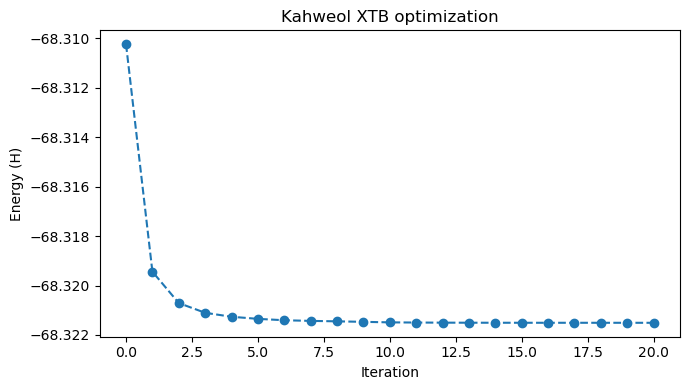

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [4]:
xyz_file_name = '../../data/md/kahweol_optim.xyz'
xyz_data, steps, energies = read_xyz_file(xyz_file_name)

# Plot the energies
plt.figure(figsize=(7,4))
plt.plot(steps, energies,'o--')
plt.xlabel('Iteration')
plt.ylabel('Energy (H)')
plt.title("Kahweol XTB optimization")
plt.tight_layout(); plt.show()

# and animate the optimization
viewer = p3d.view(width=600, height=300)
viewer.addModelsAsFrames(xyz_data)
viewer.animate({"loop": "forward"})

viewer.setViewStyle({"style": "outline", "width": 0.05})
viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})

viewer.show()

If instead we would like to see each configuration individually, we can create an interactive widget with a slider. As in the [previous section](sec:md-vis), we need a routine which reads an individual configuration at a time and returns the corresponding py3Dmol viewer.

In [9]:
def read_xyz_index(file_name, index=0):
    """Reads one configuration defined by its index from the xyz optimization file."""
    xyz_file = open(file_name, "r")
    current_index = 0
    data = ""

    # Read the number of atoms from the first line
    line = xyz_file.readline()
    natm = line.split()[0]
    data += line
    for line in xyz_file:
        if index == current_index:
            data += line
            if 'Energy' in line:
                parts = line.split()
                energy = float(parts[-1])
        if natm in line:
            parts = line.split()
            if len(parts) == 1:
                if index == current_index:
                    break
                current_index += 1
    xyz_file.close()
    return data, energy


def return_viewer(file_name, step=0):
    xyz_data_i, energy_i = read_xyz_index(file_name, step)
    
    # Uncomment if you would also like to see the energy plot
    # or comment out if you would like to skip this.
    plt.figure(figsize=(7,4))
    plt.plot(steps, energies, 'o--')
    plt.plot(step, energy_i, 'o', markersize=15)
    plt.xlabel('Iteration')
    plt.ylabel('Energy (H)')
    plt.title("Kahweol XTB optimization")
    plt.tight_layout(); plt.show()
    
    viewer = p3d.view(width=600, height=300)
    viewer.addModel(xyz_data_i)
    viewer.setViewStyle({"style": "outline", "width": 0.05})
    viewer.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
    viewer.show()

In [50]:
total_steps = steps[-1] # number of configurations in the trajectory file

# Note that the slider only works in a Jupyter notebook.
ipywidgets.interact(return_viewer, file_name=xyz_file_name,
                    step=ipywidgets.IntSlider(min=0, max=total_steps, step=1, value=3))

interactive(children=(Text(value='../../data/md/kahweol_optim.xyz', description='file_name'), IntSlider(value=…

<function __main__.return_viewer(file_name, step=0)>

## Vibrational normal modes

Now let's see how to animate and visualize vibrational normal modes. For this, we will need to determine the molecular [Hessian](sec:ir-tutorial) and perform a vibrational analysis.

In [19]:
xtb_drv = vlx.XtbDriver()
xtb_vibanalysis_drv = vlx.VibrationalAnalysis(xtb_drv)

In order to perform a vibrational analysis we need a `Molecule` object which stores the optimized geometry. To create the `Molecule` object we will read the last geometry from the `xyz` file we used in the previous [subsection](opt-vis).

In [20]:
# read the last configuration from file
kahweol_xyz, opt_energy = read_xyz_index(file_name=xyz_file_name, index=total_steps)
# create the Mlecul object
xtb_opt_kahweol = vlx.Molecule.read_xyz_string(kahweol_xyz)
# perform vibrational analysis -- diagonalize Hessian, extract frequencies and normal modes
# and calculate IR intensities.
xtb_vibanalysis_drv.compute(xtb_opt_kahweol)

                                                   Vibrational Analysis                                                   
                                                                                                                          
                                   Vibrational Mode      1                                                                
                                   ----------------------------------------------------                                   
                                   Harmonic frequency:                  44.72  cm**-1                                     
                                   Reduced mass:                       4.8483  amu                                        
                                   Force constant:                     0.0057  mdyne/A                                    
                                   IR intensity:                       1.4717  km/mol                                     
                

Now we have the frequencies, normal modes and IR intensities. In order to animate a specific normal mode, we need to write a routine which selects the mode of interest and returns it in the format required by [py3Dmol](http://3dmol.csb.pitt.edu/index.html). We would also like to plot the IR spectrum and, for this, we also need a routine which adds a Gaussian or Lorentzian broadening to the calculated IR spectrum.

In [21]:
# To animate the normal mode we will need both the geometry and the displacements 
def get_normal_mode(molecule, normal_mode):
    elements = molecule.get_labels()
    coords = molecule.get_coordinates_in_angstrom()
    natm = molecule.number_of_atoms()
    vib_xyz = "%d\n\n" % natm
    nm = normal_mode.reshape(natm, 3)
    for i in range(natm):
        # add coordinates:
        vib_xyz += elements[i] + " %15.7f %15.7f %15.7f " % (coords[i,0], coords[i,1], coords[i,2])
        # add displacements:
        vib_xyz += "%15.7f %15.7f %15.7f\n" % (nm[i,0], nm[i,1], nm[i,2])
    return vib_xyz

# Broadening function
def add_broadening(list_ex_energy, list_osci_strength, line_profile='Lorentzian', line_param=10, step=10):
        x_min = np.amin(list_ex_energy) - 50
        x_max = np.amax(list_ex_energy) + 50
        x = np.arange(x_min, x_max, step)
        y = np.zeros((len(x)))
        #print(x)
        #print(y)

        # go through the frames and calculate the spectrum for each frame
        for xp in range(len(x)):
            for e, f in zip(list_ex_energy, list_osci_strength):
                if line_profile == 'Gaussian':
                    y[xp] += f * np.exp(-(
                        (e - x[xp]) / line_param)**2)
                elif line_profile == 'Lorentzian':
                    y[xp] += 0.5 * line_param * f / (np.pi * (
                        (x[xp] - e)**2 + 0.25 * line_param**2))
        return x, y

After adding the broadening, we can plot the spectrum and then animate a specific normal mode, selected based on its index.

In [22]:
wvn, ir = xtb_vibanalysis_drv.vib_frequencies, xtb_vibanalysis_drv.ir_intensities
wvng, irg = add_broadening(wvn, ir, line_profile='Gaussian', line_param=10, step=2)

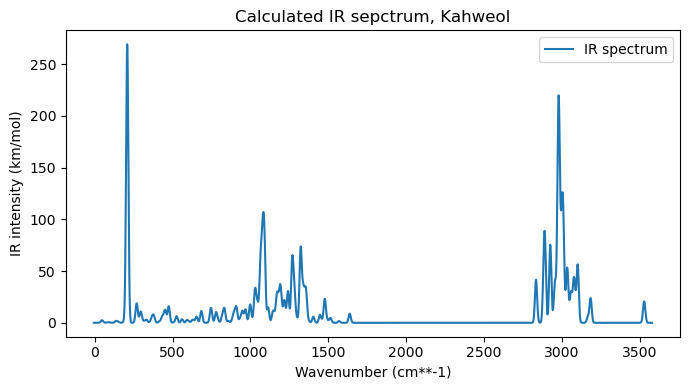




       Normal mode 64: 1078.75 cm-1, 68.62 km/mol.


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [39]:
# Plot the IR spectra
plt.figure(figsize=(7,4))

# Plot the IR spectrum
plt.plot(wvng, irg, label='IR spectrum')
plt.xlabel('Wavenumber (cm**-1)')
#plt.axis(xmin=3200, xmax=3500)
#plt.axis(ymin=-0.2, ymax=1.5)
plt.ylabel('IR intensity (km/mol)')
plt.title("Calculated IR sepctrum, Kahweol")
plt.legend()
plt.tight_layout(); plt.show()

# Visualize the vibrational mode
index = 64
print("\n\n\n       Normal mode %d: %.2f cm-1, %.2f km/mol." % (index, 
                                                                xtb_vibanalysis_drv.vib_frequencies[index-1],
                                                                xtb_vibanalysis_drv.ir_intensities[index-1]))
normal_mode = get_normal_mode(xtb_opt_kahweol, xtb_vibanalysis_drv.normal_modes[index-1])
view = p3d.view(viewergrid=(1,1), width=600, height=300)
view.addModel(normal_mode, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}})

view.setViewStyle({"style": "outline", "width": 0.05})
view.setStyle({"stick": {}, "sphere": {"scale": 0.25}})

view.animate({'loop': 'backAndForth'})
view.zoomTo()
view.show()

To make a more interactive normal mode selection, we can create a slider using the [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/index.html) Python module for Jupyter notebooks. To make use of the slider widget, we first need a routine which can plot the IR spectrum and animate a specific normal mode selected based on its index.

In [45]:
def vibration_viewer(index):
    freq = xtb_vibanalysis_drv.vib_frequencies[index-1]
    ir_intens = xtb_vibanalysis_drv.ir_intensities[index-1]
    # Plot the IR spectrum
    plt.figure(figsize=(7,4))
    plt.plot(wvng, irg)
    plt.plot(freq, ir_intens, 'o',  markersize=10)
    plt.xlabel('Wavenumber (cm**-1)')
    plt.ylabel('IR intensity (km/mol)')
    plt.title("Calculated IR sepctrum, Kahweol")
    plt.tight_layout(); plt.show()
    
    normal_mode = get_normal_mode(xtb_opt_kahweol, xtb_vibanalysis_drv.normal_modes[index-1])
    view = p3d.view(viewergrid=(1,1), width=600, height=300)
    view.addModel(normal_mode, "xyz", {'vibrate': {'frames':10,'amplitude':0.75}})
    view.setViewStyle({"style": "outline", "width": 0.05})
    view.setStyle({"stick": {}, "sphere": {"scale": 0.25}})
    view.animate({'loop': 'backAndForth'})
    view.zoomTo()
    view.show()

In [49]:
no_norm_modes = xtb_vibanalysis_drv.vib_frequencies.shape[0] # number of vibrational modes

# Note that the slider only works in a Jupyter notebook.
ipywidgets.interact(vibration_viewer,
                    index=ipywidgets.IntSlider(min=1, max=no_norm_modes, step=1, value=92))

interactive(children=(IntSlider(value=92, description='index', max=141, min=1), Output()), _dom_classes=('widg…

<function __main__.vibration_viewer(index)>